In [1]:
import pandas as pd
import os 
import numpy as np
import scipy as sp
import scipy.stats as stats
import Bio
import rpy2
%load_ext rpy2.ipython

# Section 1: Run pseudotime analysis with monocle

In [ ]:
%%R

###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
library(gridExtra)
library(grid)
library(stringr)
library(scImpute)
library(SummarizedExperiment)
###readin1
# scdata <- readRDS("scImpute_all_k55/parental_removed.rds")
load(file="metaneighbor/041718_post_clust_overclust.RData")
scdata <- scdata_clustd

In [ ]:
%%R

#####get variable genes
###clean data first
library(M3Drop)
cellLabels <- colData(scdata)$Study_ID

m3dGenes <- M3DropCleanData(
    counts(scdata),
    labels = cellLabels,
    is.counts = TRUE,
    min_detected_genes = 2000
)
###Brennecke method from M3Drop
Brennecke_HVG <- BrenneckeGetVariableGenes(
    m3dGenes$data,
    fdr = 0.05,
    minBiolDisp = 0.3
)

print(length(Brennecke_HVG))

# M3DropDifferentialExpression(
#     m3dGenes$data, 
#     mt_method="bon", 
#     mt_threshold=0.01, 
#     suppress.plot=FALSE)

In [ ]:
%%R
#####format for monocle
d <- counts(scdata)[which(rownames(counts(scdata)) %in% Brennecke_HVG), ]
d <- d[!duplicated(rownames(d)), ]

colnames(d) <- 1:ncol(d)
geneNames <- rownames(d)
rownames(d) <- 1:nrow(d)

pd <- data.frame(timepoint = cellLabels)
pd <- new("AnnotatedDataFrame", data=pd)
fd <- data.frame(gene_short_name = geneNames)
fd <- new("AnnotatedDataFrame", data=fd)

In [ ]:
%%R
#######run monocle
library(monocle)

dCellData <- newCellDataSet(d, phenoData = pd, featureData = fd, expressionFamily = tobit())
dCellData <- setOrderingFilter(dCellData, which(geneNames %in% Brennecke_HVG))
dCellData <- estimateSizeFactors(dCellData)
dCellDataSet <- reduceDimension(dCellData, pseudo_expr = 1)
dCellDataSet <- orderCells(dCellDataSet, reverse = FALSE)
plot_cell_trajectory(dCellDataSet)

####save files
saveRDS(dCellData, file="monocle/dCellData.rds")
saveRDS(dCellDataSet, file="monocle/dCellDataSet.rds")

# Section 2: Visualize

In [2]:
%%R

##load up data from monocle
library(monocle)
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
library(gridExtra)
library(grid)
library(stringr)
library(scImpute)
library(SummarizedExperiment)
##
dCellData <- readRDS("monocle/dCellData.rds")
dCellDataSet <- readRDS("monocle/dCellDataSet.rds")

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Biobase

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked


Error in loadRDS("monocle/dCellData.rds") : 
  could not find function "loadRDS"


/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:Matrix’:

    expand


  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:base’:

    expand.grid


  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: IRanges

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: GenomeInfoDb

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: DelayedArray

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinte

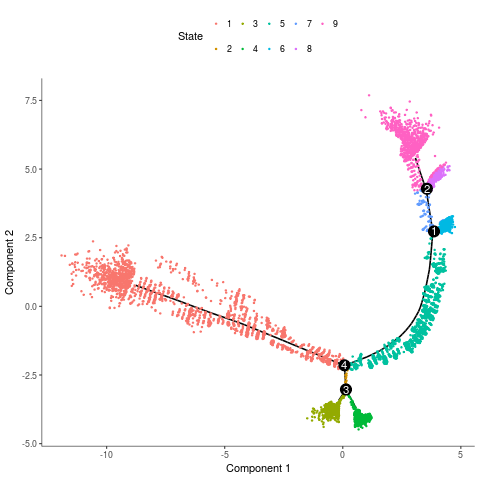

In [36]:
%%R

plot_cell_trajectory(dCellDataSet,cell_size = 0.5)

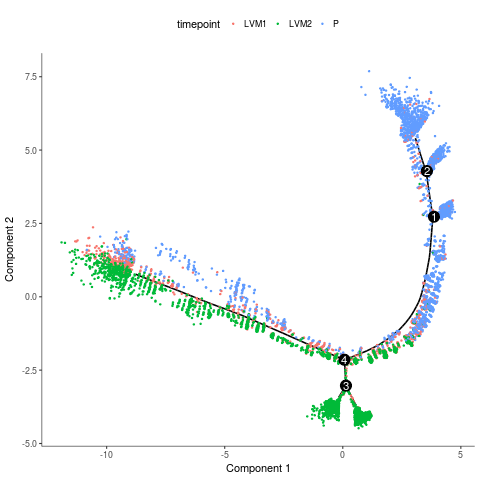

In [37]:
%%R

plot_cell_trajectory(dCellDataSet, color_by = "timepoint",cell_size = 0.5)

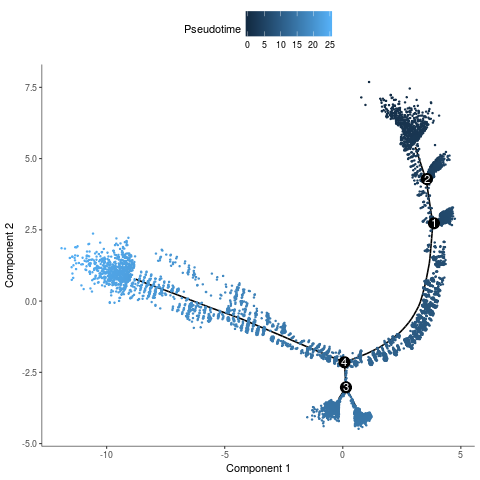

In [45]:
%%R
#####reorder pseudotime root
dCellDataSet <- orderCells(dCellDataSet, root_state = c(9.0))
plot_cell_trajectory(dCellDataSet, color_by = "Pseudotime",cell_size = 0.5)

In [39]:
%%R
####read in cluster ids into pseudotime data
load(file="metaneighbor/041718_post_clust_overclust.RData")
scdata <- scdata_clustd

dCellDataSet$Celltype <- colData(scdata)$Celltype

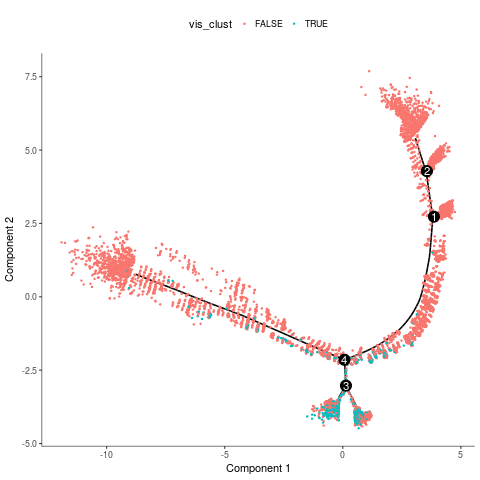

In [40]:
%%R

vis_cluster <- "LVM2_1"
####read target cluster for visualization into object
tmp <- dCellDataSet$Celltype
tmp <- (tmp == vis_cluster)
dCellDataSet$vis_clust <- tmp
####plot
plot_cell_trajectory(dCellDataSet, color_by = "vis_clust", cell_size = 0.5) +
    ggtitle(paste("Cluster",toString(vis_cluster),sep=" "))

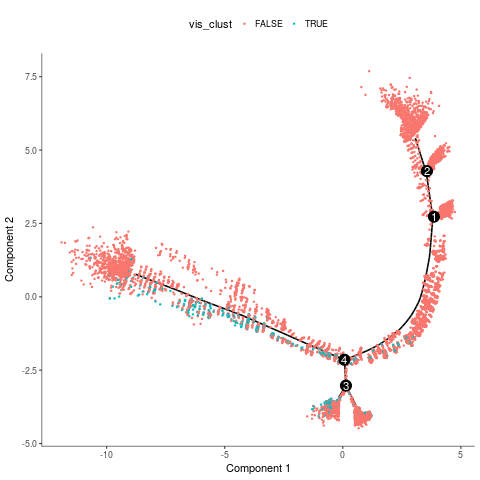

In [41]:
%%R

vis_cluster <- "LVM2_2"
####read target cluster for visualization into object
tmp <- dCellDataSet$Celltype
tmp <- (tmp == vis_cluster)
dCellDataSet$vis_clust <- tmp
####plot
plot_cell_trajectory(dCellDataSet, color_by = "vis_clust", cell_size = 0.5) +
    ggtitle(paste("Cluster",toString(vis_cluster),sep=" "))

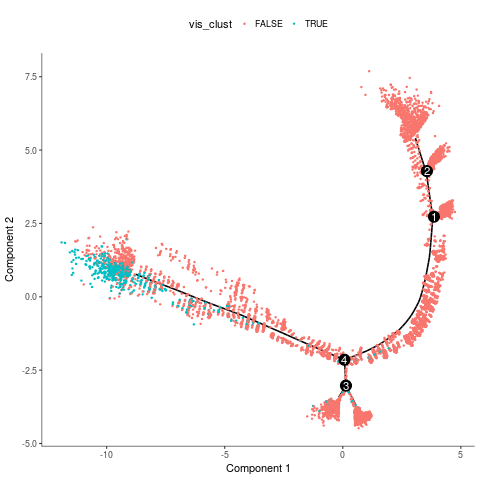

In [42]:
%%R

vis_cluster <- "LVM2_3"
####read target cluster for visualization into object
tmp <- dCellDataSet$Celltype
tmp <- (tmp == vis_cluster)
dCellDataSet$vis_clust <- tmp
####plot
plot_cell_trajectory(dCellDataSet, color_by = "vis_clust", cell_size = 0.5) +
    ggtitle(paste("Cluster",toString(vis_cluster),sep=" "))

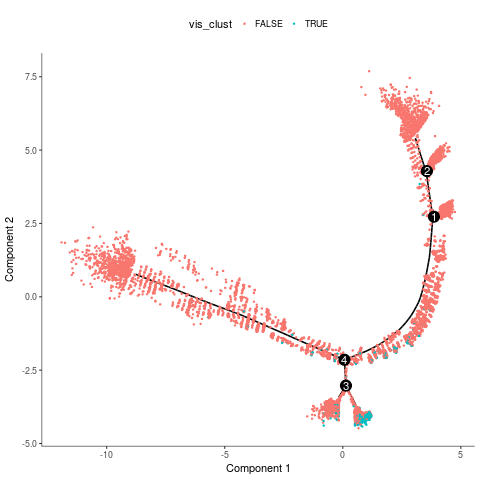

In [43]:
%%R

vis_cluster <- "LVM2_4"
####read target cluster for visualization into object
tmp <- dCellDataSet$Celltype
tmp <- (tmp == vis_cluster)
dCellDataSet$vis_clust <- tmp
####plot
plot_cell_trajectory(dCellDataSet, color_by = "vis_clust", cell_size = 0.5) +
    ggtitle(paste("Cluster",toString(vis_cluster),sep=" "))

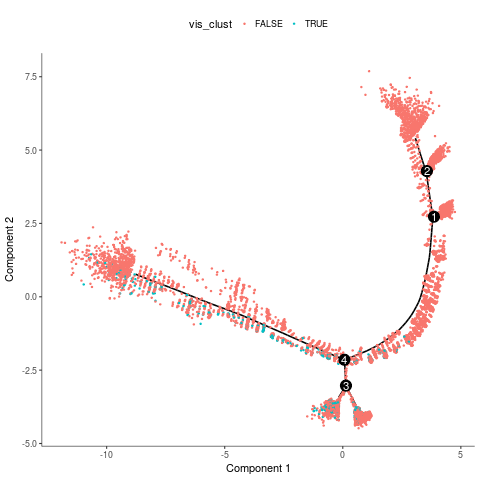

In [44]:
%%R

vis_cluster <- "LVM2_5"
####read target cluster for visualization into object
tmp <- dCellDataSet$Celltype
tmp <- (tmp == vis_cluster)
dCellDataSet$vis_clust <- tmp
####plot
plot_cell_trajectory(dCellDataSet, color_by = "vis_clust", cell_size = 0.5) +
    ggtitle(paste("Cluster",toString(vis_cluster),sep=" "))

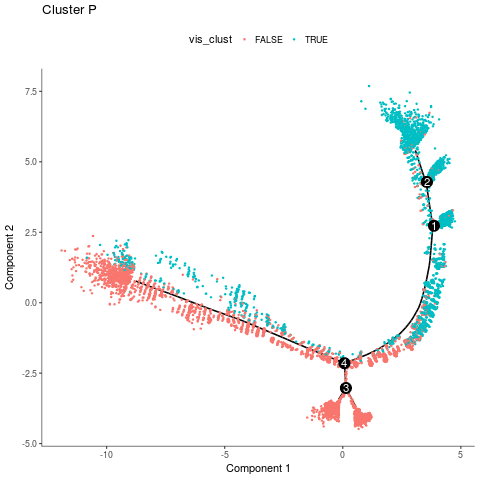

In [48]:
%%R

vis_cluster <- "P"
####read target cluster for visualization into object
tmp <- dCellDataSet$timepoint
tmp <- (tmp == vis_cluster)
dCellDataSet$vis_clust <- tmp
####plot
plot_cell_trajectory(dCellDataSet, color_by = "vis_clust", cell_size = 0.5) +
    ggtitle(paste("Cluster",toString(vis_cluster),sep=" "))

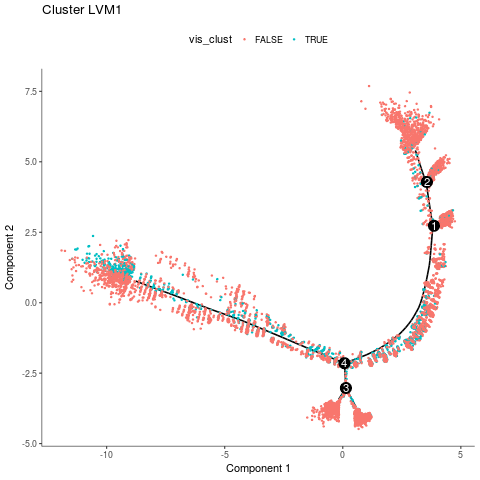

In [49]:
%%R

vis_cluster <- "LVM1"
####read target cluster for visualization into object
tmp <- dCellDataSet$timepoint
tmp <- (tmp == vis_cluster)
dCellDataSet$vis_clust <- tmp
####plot
plot_cell_trajectory(dCellDataSet, color_by = "vis_clust", cell_size = 0.5) +
    ggtitle(paste("Cluster",toString(vis_cluster),sep=" "))

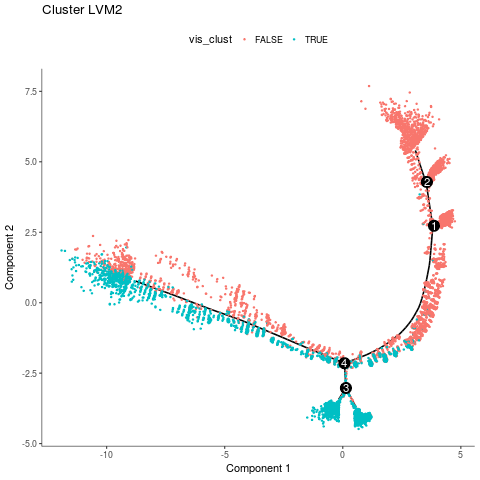

In [50]:
%%R

vis_cluster <- "LVM2"
####read target cluster for visualization into object
tmp <- dCellDataSet$timepoint
tmp <- (tmp == vis_cluster)
dCellDataSet$vis_clust <- tmp
####plot
plot_cell_trajectory(dCellDataSet, color_by = "vis_clust", cell_size = 0.5) +
    ggtitle(paste("Cluster",toString(vis_cluster),sep=" "))

# Section 3: Analysis of 'States' identified by monocle

In [18]:
%%R

##load up data from monocle
library(monocle)
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
library(gridExtra)
library(grid)
library(stringr)
library(scImpute)
library(SummarizedExperiment)
##
dCellData <- readRDS("monocle/dCellData.rds")
dCellDataSet <- readRDS("monocle/dCellDataSet.rds")

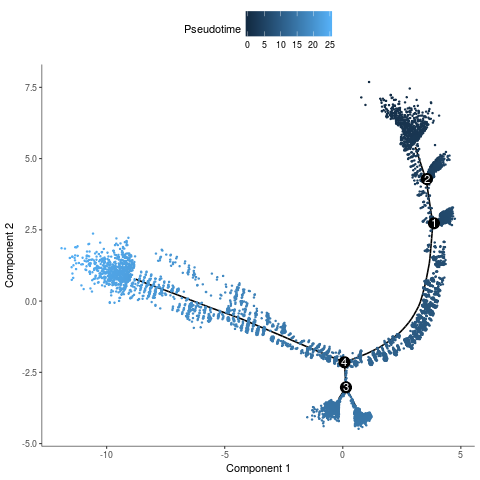

In [44]:
%%R
dCellDataSet <- orderCells(dCellDataSet, root_state = c(9.0))
plot_cell_trajectory(dCellDataSet, color_by = "Pseudotime",cell_size = 0.5)

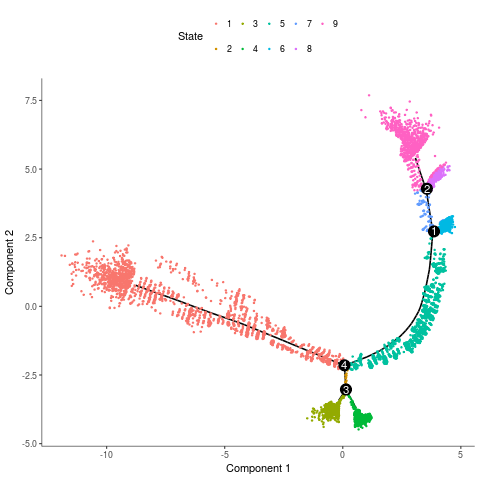

In [4]:
%%R

plot_cell_trajectory(dCellDataSet, color_by = "State",cell_size = 0.5)

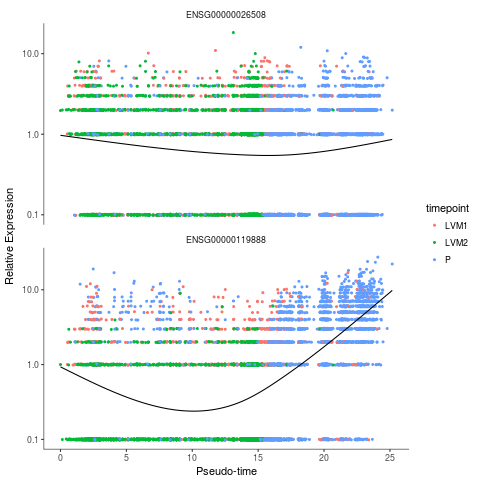

In [43]:
%%R

expressed_genes <-  row.names(fData(dCellDataSet))
filtered <- dCellDataSet[expressed_genes,]
my_genes <- row.names(subset(fData(filtered),
          gene_short_name %in% c("ENSG00000026508","ENSG00000119888","ENSG00000272398")))
cds_subset <- filtered[my_genes,]
plot_genes_in_pseudotime(cds_subset, color_by = "timepoint")

In [5]:
%%R
####look at branch point 4
BEAM_res <- BEAM(dCellDataSet, branch_point = 4, cores = 16)
BEAM_res <- BEAM_res[order(BEAM_res$qval),]
BEAM_res <- BEAM_res[,c("gene_short_name", "pval", "qval")]
saveRDS(BEAM_res, file="monocle/BEAM_res.rds")


In [26]:
%%R

##load up data from branch point 4 analysis
library(monocle)
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
library(gridExtra)
library(grid)
library(stringr)
library(scImpute)
library(SummarizedExperiment)
###
BEAM_res <- readRDS("monocle/BEAM_res.rds")

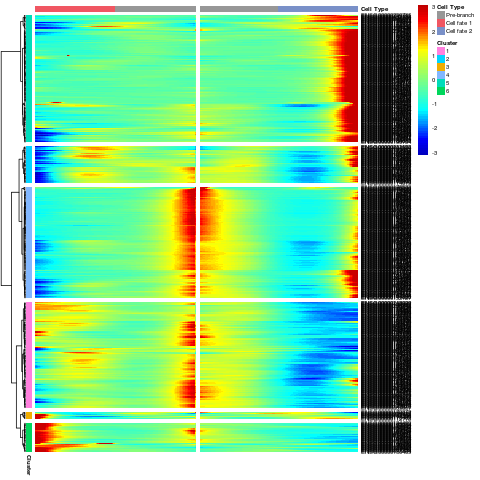

In [32]:
%%R

plot_genes_branched_heatmap(dCellDataSet[row.names(subset(BEAM_res,
                                          qval < 1e-7)),],
                                          branch_point = 4,
#                                           num_clusters = 4,
                                          cores = 16,
                                          use_gene_short_name = T,
                                          show_rownames = T)